In [33]:
from sklearn.linear_model import LogisticRegression
import numpy as np
import matplotlib.pyplot as plt
import pymysql.cursors
import us
import json
from sklearn.gaussian_process.kernels import RBF
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.metrics import accuracy_score
from sklearn import metrics
import pickle

In [3]:
states = ["Alaska", "Alabama", "Arkansas", "Arizona", "California", "Colorado", "Connecticut", "District of Columbia", "Delaware", "Florida", "Georgia", "Hawaii", "Iowa", "Idaho", "Illinois", "Indiana", "Kansas", "Kentucky", "Louisiana", "Massachusetts", "Maryland", "Maine", "Michigan", "Minnesota", "Missouri", "Mississippi", "Montana", "North Carolina", "North Dakota", "Nebraska", "New Hampshire", "New Jersey", "New Mexico", "Nevada", "New York", "Ohio", "Oklahoma", "Oregon", "Pennsylvania", "Rhode Island", "South Carolina", "South Dakota", "Tennessee", "Texas", "Utah", "Virginia", "Vermont", "Washington", "Wisconsin", "West Virginia", "Wyoming"]
zones = ['HST','AKST', 'PST','MST', 'CST', 'EST']
# timezone to abbr map
abbr_map = {'America/Anchorage': 'AKST', 'America/Phoenix': 'MST', 'America/Denver': 'MST', 'Pacific/Honolulu': 'HST', 'America/New_York': 'EST', 'America/North_Dakota/Center': 'CST', 'America/Los_Angeles': 'PST', 'America/Chicago': 'CST', 'America/Indiana/Indianapolis': 'EST'}

# create mapping of state to timezone
timezone_map = dict()

# build timezone_map of state to timezone name
for state in states:
    s = us.states.lookup(state)
    timezone_map[state] = abbr_map[s.capital_tz]

print(timezone_map)
print(set(timezone_map.values()))


{'Alaska': 'AKST', 'Alabama': 'CST', 'Arkansas': 'CST', 'Arizona': 'MST', 'California': 'PST', 'Colorado': 'MST', 'Connecticut': 'EST', 'District of Columbia': 'EST', 'Delaware': 'EST', 'Florida': 'EST', 'Georgia': 'EST', 'Hawaii': 'HST', 'Iowa': 'CST', 'Idaho': 'MST', 'Illinois': 'CST', 'Indiana': 'EST', 'Kansas': 'CST', 'Kentucky': 'EST', 'Louisiana': 'CST', 'Massachusetts': 'EST', 'Maryland': 'EST', 'Maine': 'EST', 'Michigan': 'EST', 'Minnesota': 'CST', 'Missouri': 'CST', 'Mississippi': 'CST', 'Montana': 'MST', 'North Carolina': 'EST', 'North Dakota': 'CST', 'Nebraska': 'CST', 'New Hampshire': 'EST', 'New Jersey': 'EST', 'New Mexico': 'MST', 'Nevada': 'PST', 'New York': 'EST', 'Ohio': 'EST', 'Oklahoma': 'CST', 'Oregon': 'PST', 'Pennsylvania': 'EST', 'Rhode Island': 'EST', 'South Carolina': 'EST', 'South Dakota': 'CST', 'Tennessee': 'CST', 'Texas': 'CST', 'Utah': 'MST', 'Virginia': 'EST', 'Vermont': 'EST', 'Washington': 'PST', 'Wisconsin': 'CST', 'West Virginia': 'EST', 'Wyoming': 'M

In [4]:
# load dataset from mysql
# Connect to the database
connection = pymysql.connect(host='localhost',
                             user='root',
                             password='Qawsedrftg9!',
                             db='reddit_data',
                             charset='utf8mb4',
                             cursorclass=pymysql.cursors.DictCursor)


# load users and cleaned tables
with connection.cursor() as cursor:
    sql = "SELECT * FROM `users`"
    cursor.execute(sql)
    users_rows = cursor.fetchall()
    sql = "SELECT username, timestamp_arr FROM `cleaned`"
    cursor.execute(sql)
    cleaned_rows = cursor.fetchall()

In [5]:
# create mapping of username -> state
loc_table = dict()
for row in users_rows:
    loc = row['location']
    
    if loc not in states:
        # discard
        continue
    else:
        loc_table[row['username']] = loc

print("Created mapping of %d users to %d states" % (len(loc_table), len(set(loc_table.values()))))

Created mapping of 69247 users to 51 states


In [7]:
# create dataset
X = []
y = []
usernames = []

# extract data from rows
for i in range(len(cleaned_rows)):
    row = cleaned_rows[i]
    
    # convert to int list
    times = json.loads(row['timestamp_arr'].replace("\'", "\""))
    times = np.array(times).astype(np.float)
    
    # discard non-US entries
    username = row['username']
    if(username == '[deleted]') or username not in loc_table:
        continue
        
    zone = timezone_map[loc_table[username]]
    # normalize time vector
    times = times / np.linalg.norm(times)

    X.append(times)
    y.append(zone)
    usernames.append(username)
    
    if(i%10000 == 0):
        print("Processed %d entries" % i)

Processed 0 entries
Processed 10000 entries
Processed 20000 entries
Processed 30000 entries
Processed 50000 entries
Processed 60000 entries
Processed 70000 entries


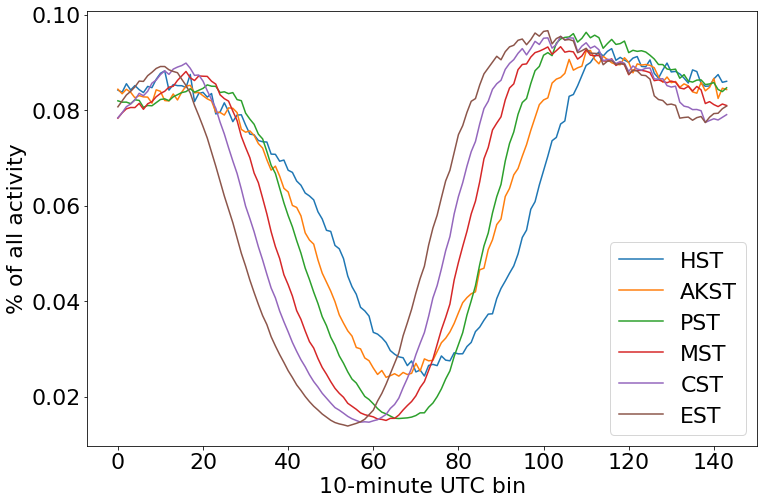

In [22]:
# for each timezone, sum up vector and graph
sum_table = dict()
count_table = dict()
for zone in zones:
    sum_table[zone] = np.zeros(144)
    count_table[zone] = 0

for (i, x) in enumerate(X):
    sum_table[y[i]] += x
    count_table[y[i]] += 1
    
    
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams.update({'font.size': 22})
for zone in zones:
    # average each timezone's sum by number of occurrences
    sum_table[zone] /= count_table[zone]
    plt.plot(range(144), sum_table[zone], label=zone)
plt.legend(loc="lower right")
plt.ylabel("% of all activity")
plt.xlabel("10-minute UTC bin")
plt.show()

In [37]:
# split data into training and test
assert(len(X) == len(y))
l = 4 * len(y) // 5
X_train, X_test = np.array(X[0:l]), np.array(X[l:])
y_train, y_test = np.array(y[0:l]), np.array(y[l:])

print("Using %d entries for training, %d for test" % (len(X_train), len(X_test)))

Using 55396 entries for training, 13850 for test


In [42]:
# run logistical regression
log_reg = LogisticRegression(max_iter=10000000, class_weight=None, multi_class='multinomial', verbose=True, n_jobs=10)
log_reg.fit(X_train, y_train)

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:   33.5s finished


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000000,
                   multi_class='multinomial', n_jobs=10, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=True,
                   warm_start=False)

In [63]:
def top_two_perf(X_test_prob, y_test):
    c_1 = 0
    c_2 = 0
    for i, prob in enumerate(X_test_prob):
        top_2 = sorted(range(len(prob)), key=lambda i: prob[i])[-2:]
        if(log_reg.classes_[top_2[1]] == y_test[i]):
            c_1 += 1
            c_2 += 1
        elif(log_reg.classes_[top_2[0]] == y_test[i]):
            c_2 += 1

    print(c_1, c_2, len(X_test))

In [45]:
score = log_reg.score(X_test, y_test)
print(score)

y_test_pred_log = log_reg.predict(X_test)
print(metrics.classification_report(y_test, y_test_pred_log, digits=3))

0.4825270758122744
              precision    recall  f1-score   support

        AKST      0.000     0.000     0.000       190
         CST      0.321     0.160     0.213      3927
         EST      0.529     0.870     0.658      6433
         HST      0.100     0.006     0.012       163
         MST      0.274     0.022     0.041      1666
         PST      0.360     0.288     0.320      1471

    accuracy                          0.483     13850
   macro avg      0.264     0.224     0.207     13850
weighted avg      0.409     0.483     0.405     13850



/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
# We use OneVsRestClassifier for multi-label prediction
from sklearn.multiclass import OneVsRestClassifier
from sklearn import svm

kernel = 1.0 * RBF(1.0)

# Run classifier
classifier = svm.SVC(random_state=0, verbose=1, kernel=kernel, probability=True)
classifier.fit(X_train, y_train)
y_score = classifier.decision_function(X_test)

NameError: name 'RBF' is not defined

In [41]:
print(classifier.score(X_train, y_train))
print(classifier.score(X_test, y_test))

0.4887175969384071
0.4851985559566787


In [68]:
# print how many top 2 predictions are correct
X_test_prob_svc = classifier.predict_proba(X_test)
top_two_perf(X_test_prob_svc, y_test)

X_test_prob_reg = log_reg.predict_proba(X_test)
top_two_perf(X_test_prob_reg, y_test)



22903 35676 46164
22360 35296 46164


In [34]:
# compute precision and recall

classifier = pickle.load(open("models/svc.model", 'rb'))
y_test_pred = classifier.predict(X_test)

In [36]:
print(metrics.classification_report(y_test, y_test_pred, digits=3))

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

        AKST      0.000     0.000     0.000       648
         CST      0.269     0.019     0.036     13011
         EST      0.500     0.965     0.659     21561
         HST      0.000     0.000     0.000       648
         MST      0.000     0.000     0.000      5447
         PST      0.378     0.284     0.324      4849

    accuracy                          0.486     46164
   macro avg      0.191     0.211     0.170     46164
weighted avg      0.349     0.486     0.352     46164



In [69]:
# save models
pickle.dump(classifier, open("svc.model", 'wb'))
pickle.dump(log_reg, open("log_reg.model", 'wb'))

In [70]:
# save probability vectors as map of username -> vector
table = dict()
X_prob = classifier.predict_proba(X)

for i in range(len(X)):
    table[usernames[i]] = X_prob[i]

pickle.dump(table, open("prob_vectors.time", 'wb'))

69246
